Author: Pınar Süngü

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [2]:
#Read Data

data = pd.read_excel('Problem4.xlsx')  

Intuitively, other districts might not effect District 1, because dynamics of each district may differ like population, number of fabrics etc. 

Check the dependence / independence of districts

H0: Xt does not granger causes Yt

H1: Xt granger causes Yt

In [3]:
max_lags=8
y='District_1'

In [4]:
for i in range(len(data.columns)-1):
    results = grangercausalitytests(data[[y,data.columns[i+1]]], max_lags, verbose=False)
    p_values =[round(results[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lags)]
    print('Column {}: p_values  {}'.format(data.columns[i+1], p_values))

Column District_2: p_values  [0.3055, 0.4199, 0.2922, 0.0712, 0.1075, 0.0364, 0.4665, 0.4933]
Column District_3: p_values  [0.1776, 0.1758, 0.1021, 0.1373, 0.1383, 0.4664, 0.0196, 0.0706]
Column District_4: p_values  [0.8257, 0.4016, 0.571, 0.3495, 0.3307, 0.3021, 0.7786, 0.8032]
Column District_5: p_values  [0.7325, 0.3076, 0.224, 0.2742, 0.1639, 0.168, 0.5415, 0.6801]
Column District_6: p_values  [0.9748, 0.8216, 0.7915, 0.4601, 0.4138, 0.787, 0.587, 0.6962]
Column District_7: p_values  [0.6843, 0.8658, 0.9692, 0.936, 0.9958, 0.7775, 0.9513, 0.8151]
Column District_8: p_values  [0.7945, 0.9678, 0.9909, 0.64, 0.6064, 0.7133, 0.6469, 0.6042]
Column District_9: p_values  [0.6822, 0.8754, 0.8195, 0.927, 0.9718, 0.9002, 0.7677, 0.375]
Column District_10: p_values  [0.5299, 0.9146, 0.957, 0.9782, 0.8733, 0.3617, 0.0002, 0.1433]
Column District_11: p_values  [0.7265, 0.974, 0.967, 0.9509, 0.9679, 0.7767, 0.0664, 0.1579]


Granger causality tests suggest that other districts do not significantly effect District 1, so our problem is univarite time series forecasting problem, lets apply ARIMA

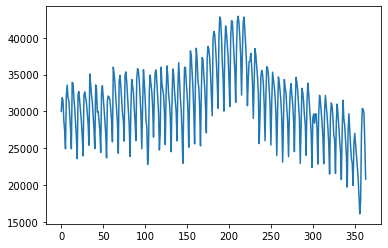

In [5]:
series = data['District_1']
series.plot()
plt.show()

In [6]:
df=data['District_1'][:-28]

In [7]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df)

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.852046
p-value                   0.803354
# lags used              16.000000
# observations          319.000000
critical value (1%)      -3.451017
critical value (5%)      -2.870643
critical value (10%)     -2.571620
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [9]:
adf_test(df.diff())

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.563838
p-value                   0.000002
# lags used              14.000000
# observations          320.000000
critical value (1%)      -3.450952
critical value (5%)      -2.870615
critical value (10%)     -2.571605
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Our serie is stationary at lag 1 

Following plots give us insight about AR and MA components, but we optimize them with auto_arima

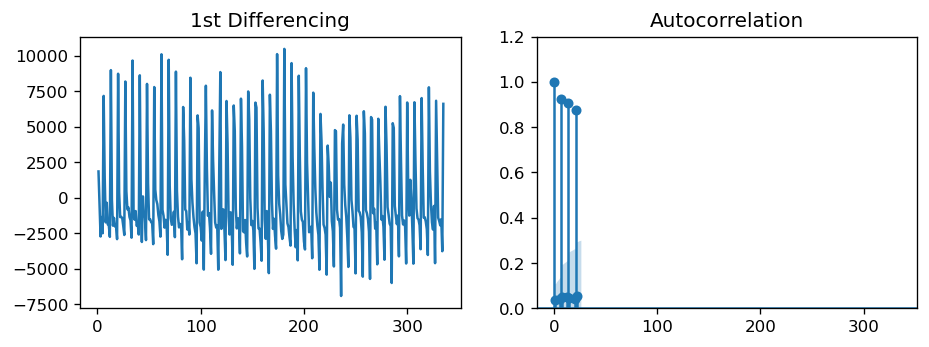

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

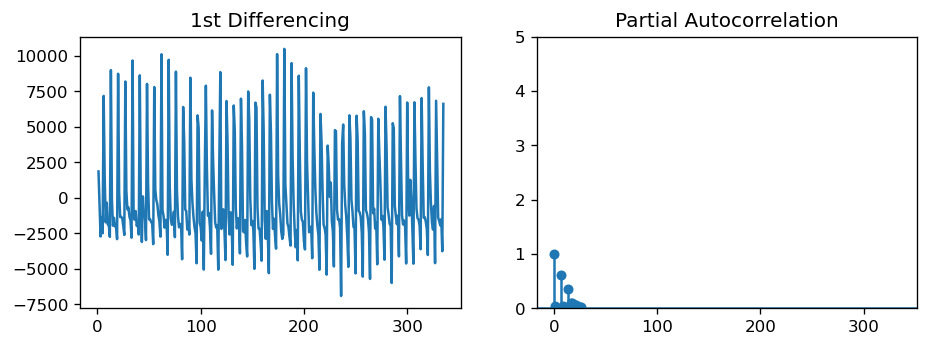

In [11]:
# PACF plot of 1st differenced series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

In [12]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6401.131, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6465.739, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6467.052, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6466.482, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6463.742, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6341.956, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6444.217, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6327.523, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6427.813, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6293.421, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6370.336, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6253.923, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6359.441, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : 

In [13]:
model = ARIMA(df, order=(3,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\pinarsungu\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.District_1   No. Observations:                  335
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3100.614
Method:                       css-mle   S.D. of innovations           2505.654
Date:                Wed, 13 Oct 2021   AIC                           6217.228
Time:                        09:43:24   BIC                           6247.741
Sample:                             1   HQIC                          6229.392
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7739     68.595     -0.011      0.991    -135.217     133.669
ar.L1.D.District_1     0.3004      0.039      7.800      0.000       0.225       0.376
ar.L2.D.District_1  

C:\Users\pinarsungu\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

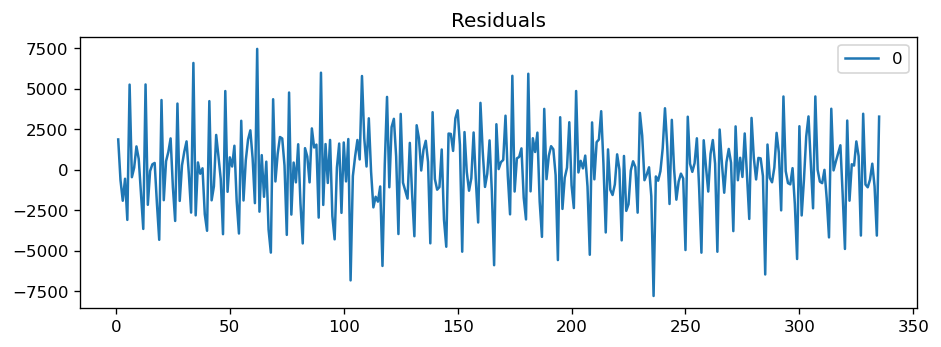

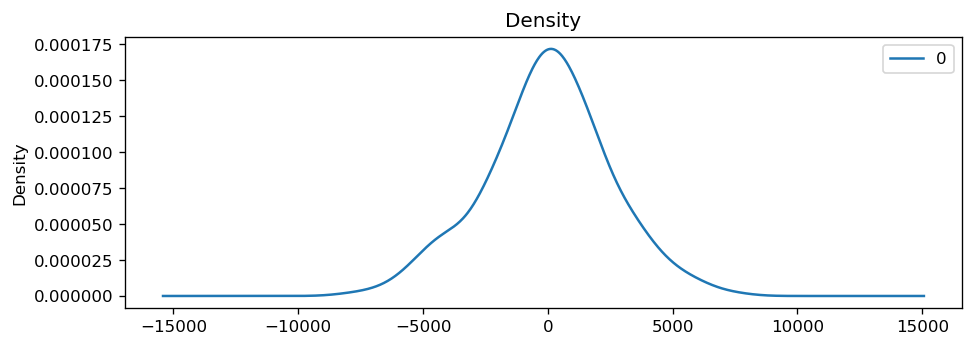

In [14]:
# Plot residual errors

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')

The residual errors seem fine with zero mean and uniform variance. Let’s plot the actuals against the fitted values using 

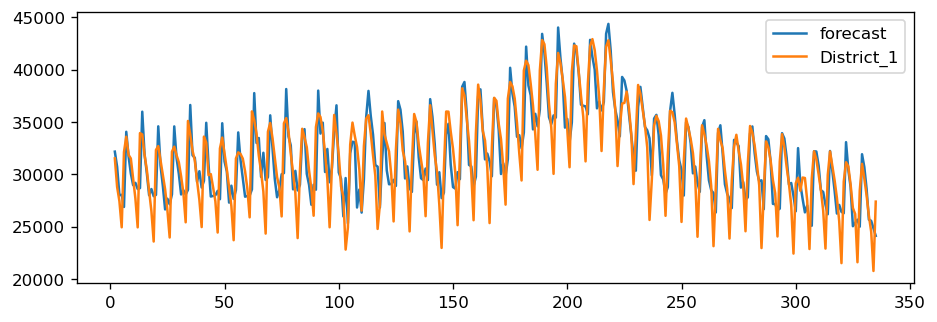

In [15]:
# Actual vs Fitted

model_fit.plot_predict(dynamic=False)
plt.show()

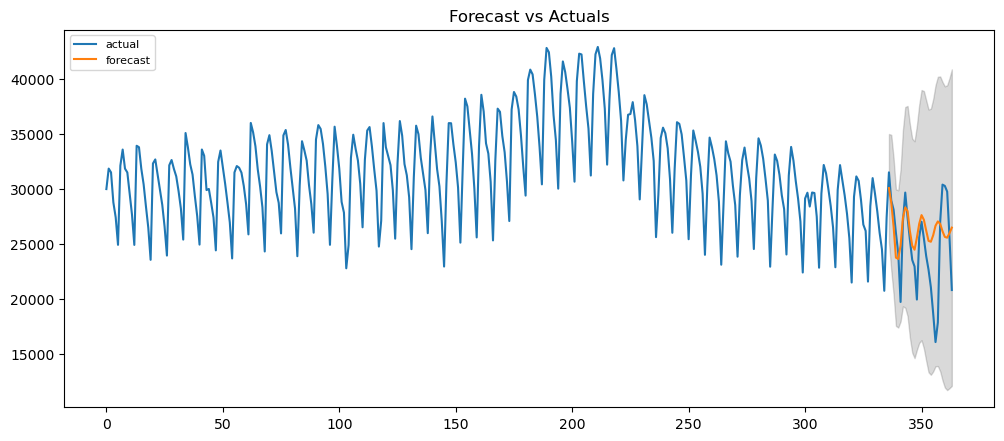

In [16]:
# Forecast

test = data['District_1'][336:364]
fc, se, conf = model_fit.forecast(28, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot

plt.figure(figsize=(12,5), dpi=100)
plt.plot(data['District_1'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

How much water saving?

In [17]:
saving = (fc_series - data['District_1'][336:]).sum()
saving

40329.120076752355

In [18]:
import scipy

In [19]:
scipy.stats.ttest_ind(a=fc_series,b=data['District_1'][336:],equal_var=False)

Ttest_indResult(statistic=1.744017484086638, pvalue=0.09028693491611853)

t test says that campaign impact is not statistically significant at 0.05 significant level

In [20]:
# Average usage during campaign period

(data['District_1'][336:]).mean()

24893.05716071429

<AxesSubplot:>

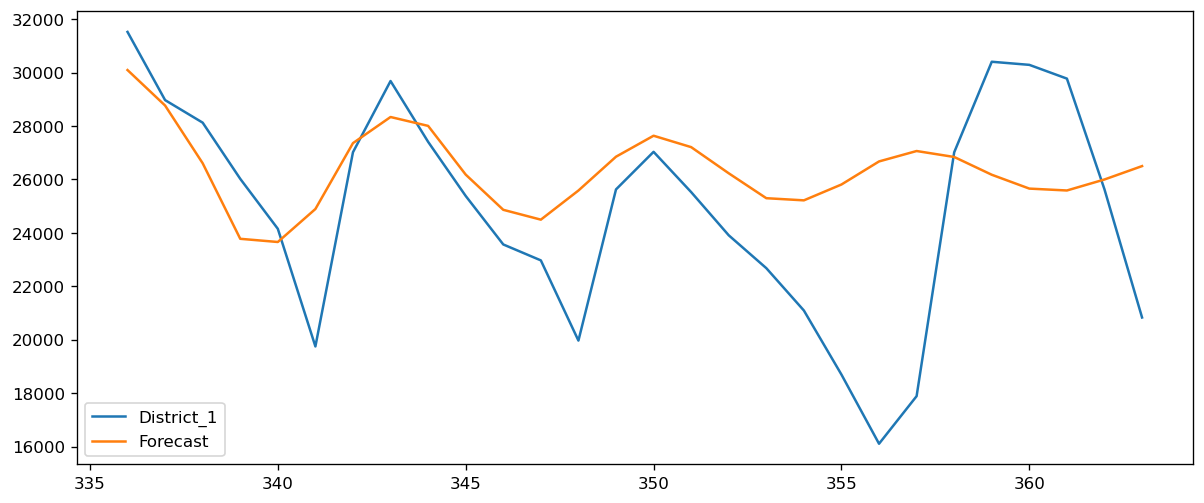

In [21]:
data['District_1'][336:].plot(figsize=(12,5),legend=True)
fc_series.plot(legend=True, label = 'Forecast')